## ORGANS: Discards

This notebook contains analysis of discarded livers, based on the `don_disp` dataset.

---

### Initialize environment

In [2]:
library(tidyverse)

In [3]:
root_path     <- here::here()
data_path     <- paste0(root_path, "/01_data")
analysis_path <- paste0(root_path, "/02_analysis")

In [4]:
setwd(data_path)

don_disp <- readRDS("clean/don_disp_clean.rds")

don_disp_full.raw <- as_tibble(read.csv("raw/06_don_disp/DONDISPOSITION_22F167Records-redacted.csv"))

don_disp_full <- don_disp_full.raw %>%
  filter(grepl("Liver", DON_ORG)) %>%
  mutate(DON_RECOV_DT_DATE = as.Date(DON_RECOV_DT, "%m/%d/%y"),
         DON_RECOV_DT_YEAR = lubridate::year(DON_RECOV_DT_DATE))

setwd(analysis_path)

---

### Analyze trends in discard data (liver disposition over time, etc.)

In [5]:
donDispByYear <- don_disp %>%
  filter(DON_RECOV_DT_YEAR %in% 2018:2021) %>%
  count(DON_RECOV_DT_YEAR, DON_DISPOSITION) %>%
  pivot_wider(id_cols = DON_DISPOSITION, names_from = DON_RECOV_DT_YEAR,
              names_prefix = "N_LIVERS_", values_from = n)

write.csv(x = donDispByYear,
          file = "output/tables/table5-liver_disposition_by_year.csv",
          row.names = F)

donDispByYear

DON_DISPOSITION,N_LIVERS_2018,N_LIVERS_2019,N_LIVERS_2020,N_LIVERS_2021
<chr>,<int>,<int>,<int>,<int>
1: Authorization Not Requested,12,13,19,21
2: Authorization Not Obtained,58,72,81,90
3: Organ Not Recovered,1753,2109,2738,3531
4: Recovered Not for Tx,437,545,542,686
5: Recovered for TX but Not Tx,725,881,871,949
6: Transplanted,7855,8373,8418,8664


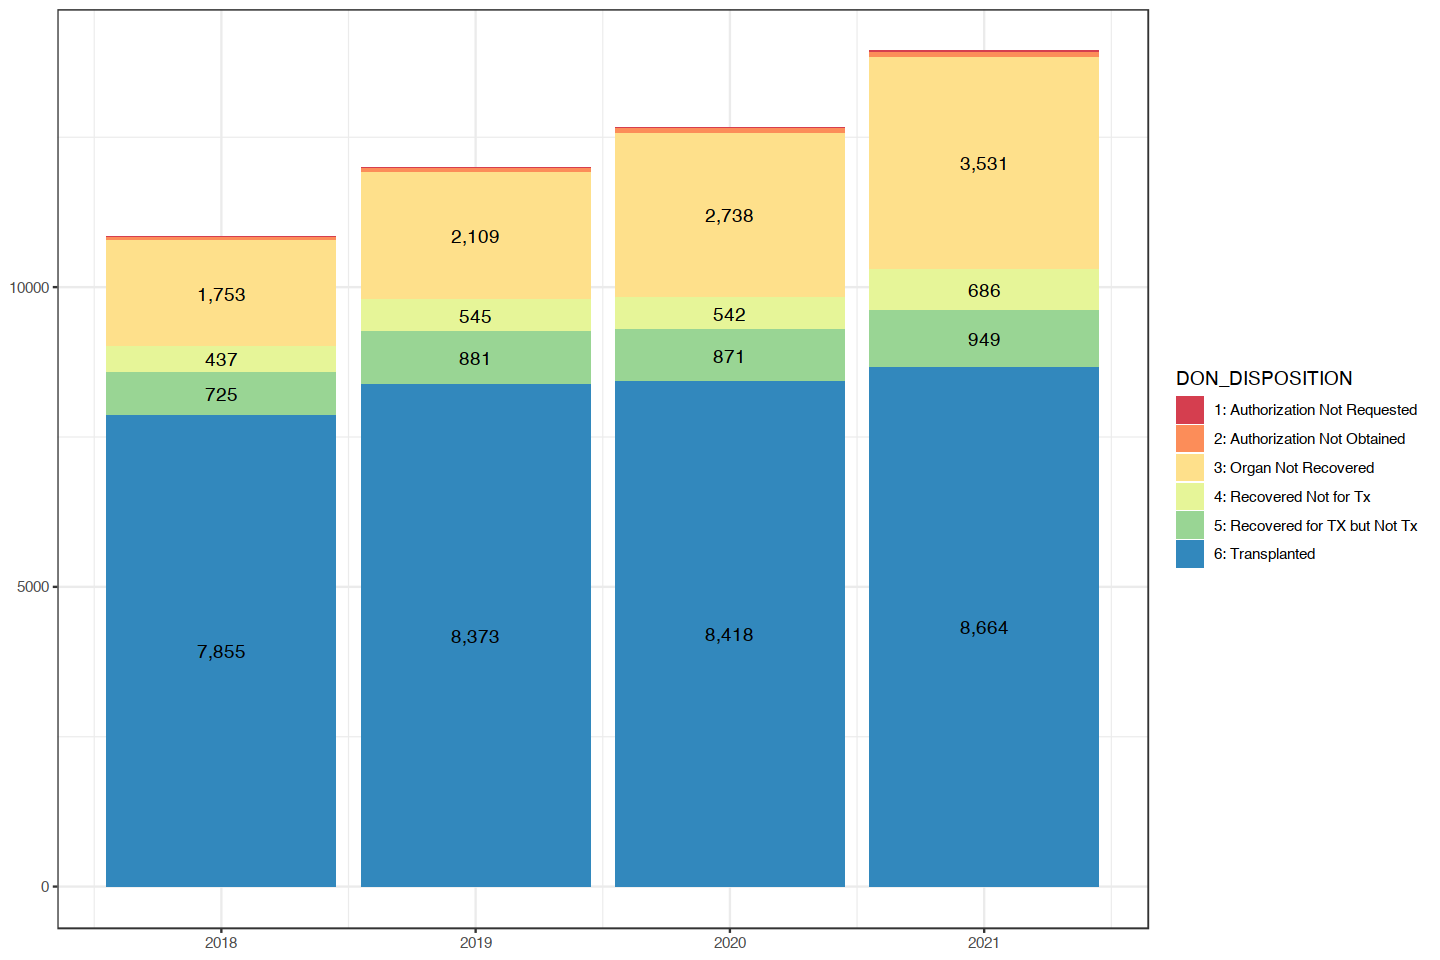

In [6]:
options(repr.plot.width = 12, repr.plot.height = 8)

donDispByYear %>%
  pivot_longer(matches("N_LIVERS_")) %>%
  mutate(YEAR = as.numeric(gsub("N_LIVERS_", "", name))) %>%
  ggplot(aes(x = YEAR, y = value, fill = DON_DISPOSITION)) +
  geom_col() +
  geom_text(aes(label = case_when(value > 100 ~ scales::comma(value, accuracy = 1))), 
            na.rm = T, position = position_stack(vjust = 0.5)) +
  scale_fill_brewer(palette = "Spectral") +
  labs(x = NULL, y = NULL) +
  theme_bw()

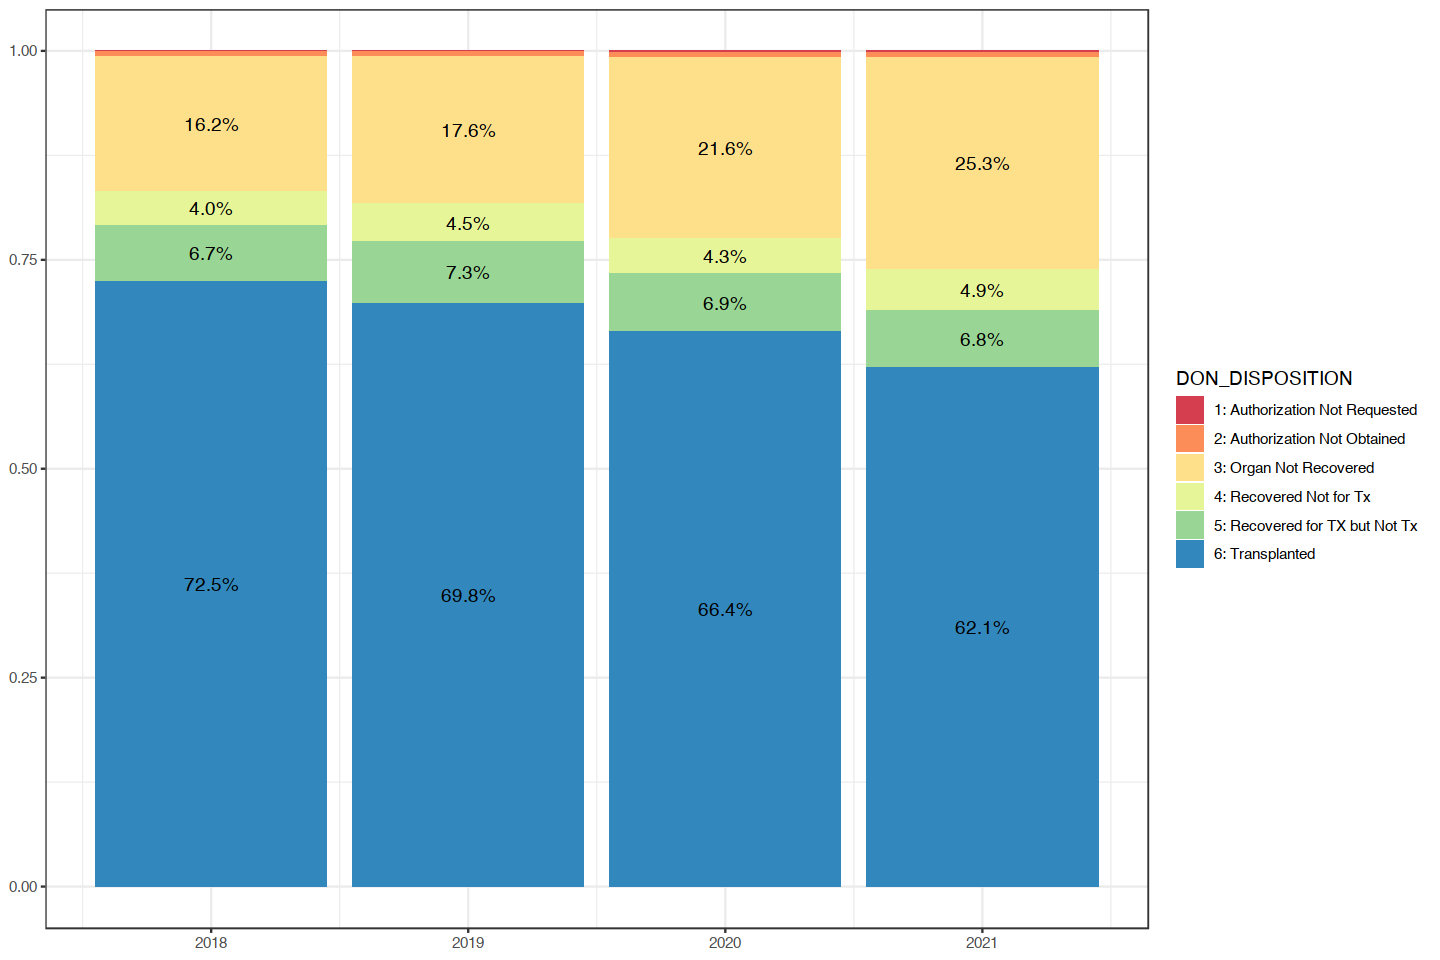

In [7]:
options(repr.plot.width = 12, repr.plot.height = 8)

donDispByYear %>%
  pivot_longer(matches("N_LIVERS_")) %>%
  mutate(YEAR = as.numeric(gsub("N_LIVERS_", "", name))) %>%
  group_by(YEAR) %>%
  mutate(pct = value / sum(value)) %>%
  ungroup() %>%
  ggplot(aes(x = YEAR, y = pct, fill = DON_DISPOSITION)) +
  geom_col() +
  geom_text(aes(label = case_when(pct > .01 ~ scales::percent(pct, accuracy = .1))), 
            na.rm = T, position = position_stack(vjust = 0.5)) +
  scale_fill_brewer(palette = "Spectral") +
  labs(x = NULL, y = NULL) +
  theme_bw()

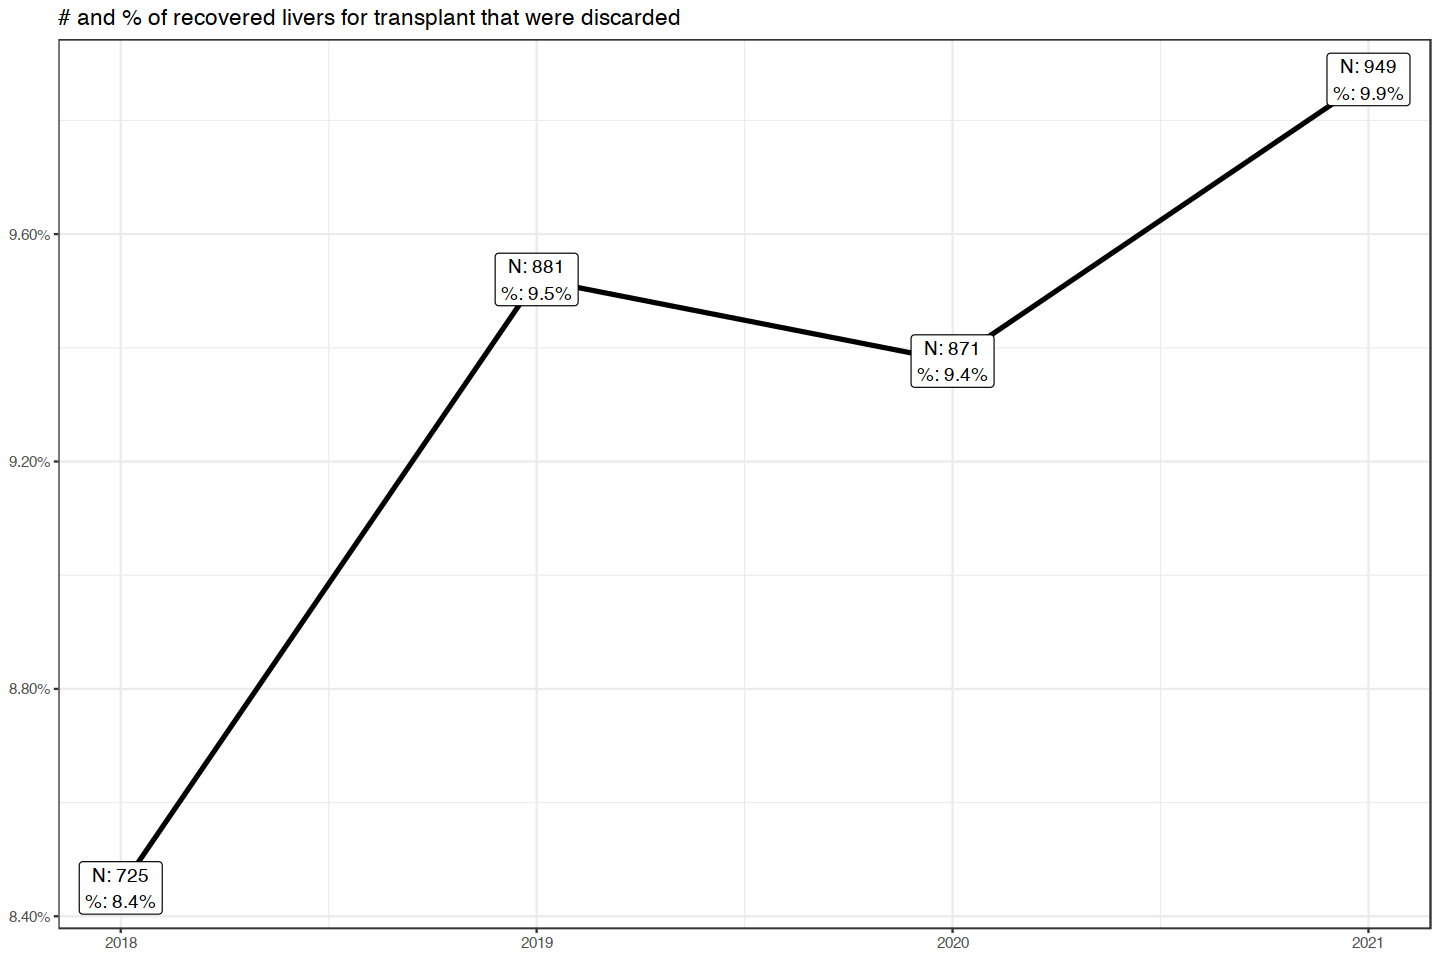

In [8]:
discardShare.plot <- donDispByYear %>%
  filter(grepl("5|6", DON_DISPOSITION)) %>%
  pivot_longer(matches("N_LIVERS")) %>%
  mutate(YEAR = as.numeric(gsub("N_LIVERS_", "", name))) %>%
  group_by(YEAR) %>%
  mutate(pct = value / sum(value)) %>%
  ungroup() %>%
  filter(grepl("5", DON_DISPOSITION)) %>%
  ggplot(aes(x = YEAR, y = pct)) +
  geom_line(size = 1.1) +
  geom_point() +
  geom_label(aes(label = paste0("N: ", 
                                scales::comma(value, accuracy = 1),
                                "\n%: ", 
                                scales::percent(pct, accuracy = 0.1)))) +
  scale_x_continuous(name = NULL) +
  scale_y_continuous(name = NULL, labels = scales::percent) +
  labs(title = "# and % of recovered livers for transplant that were discarded") +
  theme_bw()

ggsave("output/figures/fig5-number_and_share_of_discarded_livers.png",
       discardShare.plot, device = "png",
       width = 8, height = 5, unit = "in", dpi = 400)

discardShare.plot

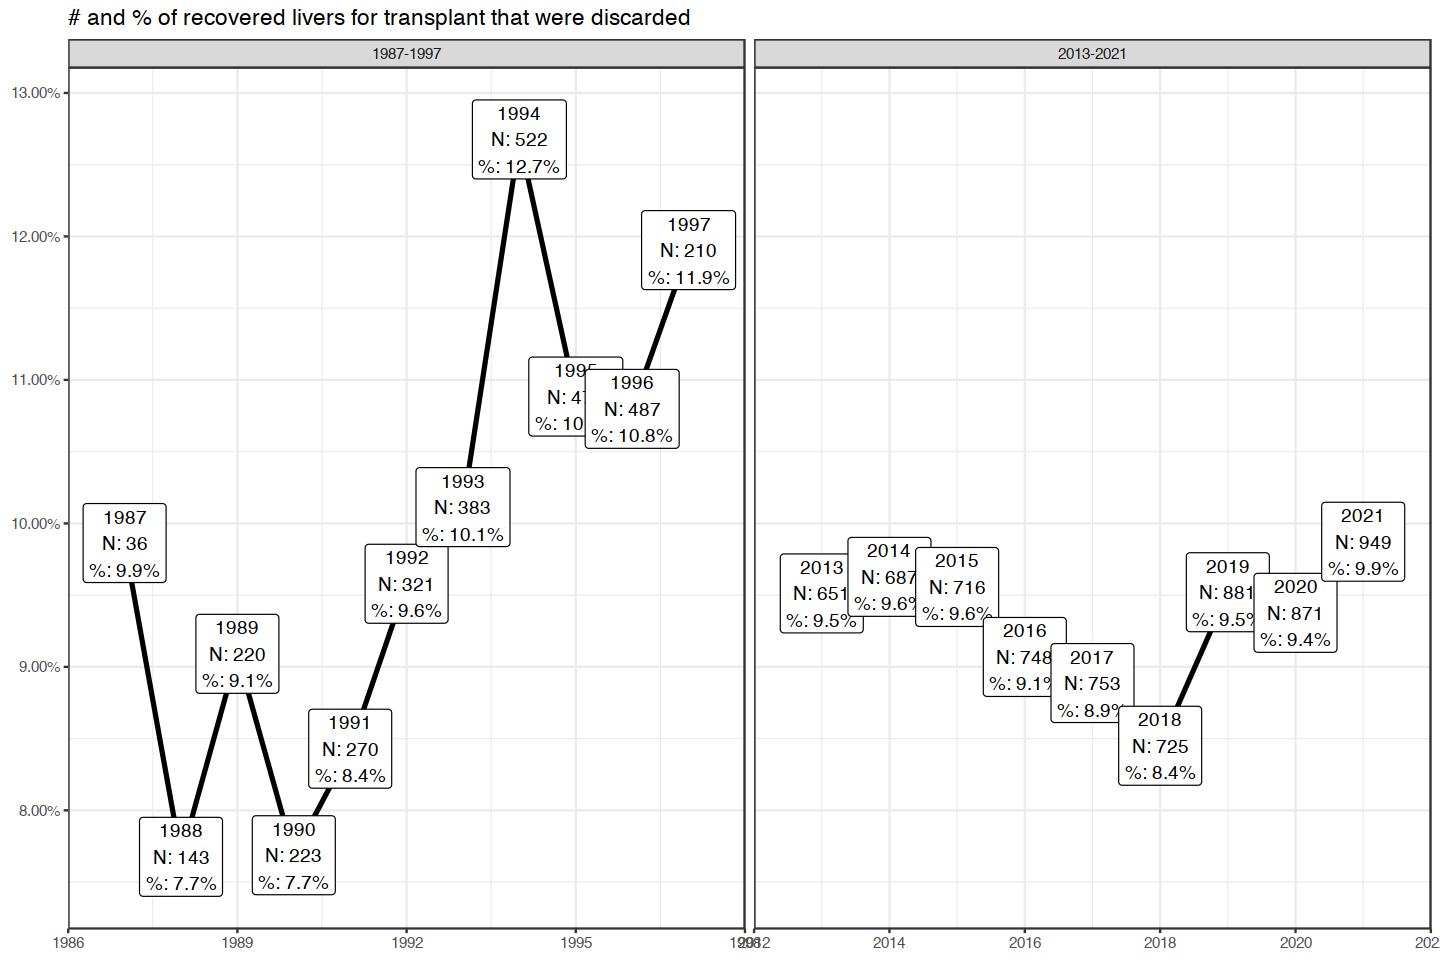

In [9]:
don_disp_full %>% 
  filter(grepl("^5|6", DON_DISPOSITION)) %>%
  count(YEAR = DON_RECOV_DT_YEAR, DON_DISPOSITION, name = "N_LIVERS") %>%
  filter(YEAR <= 2021) %>%
  group_by(YEAR) %>%
  mutate(PCT_LIVERS = N_LIVERS / sum(N_LIVERS)) %>%
  ungroup() %>%
  filter(grepl("5", DON_DISPOSITION)) %>%
  mutate(side = if_else(YEAR <= 2000, "1987-1997", "2013-2021")) %>%
  ggplot(aes(x = YEAR, y = PCT_LIVERS)) +
  geom_line(size = 1.1) +
  geom_point() +
  geom_label(aes(label = paste0(YEAR, "\nN: ", 
                                scales::comma(N_LIVERS, accuracy = 1),
                                "\n%: ", 
                                scales::percent(PCT_LIVERS, accuracy = 0.1)))) +
  scale_x_continuous(name = NULL, expand = c(0, 1)) +
  scale_y_continuous(name = NULL, labels = scales::percent, expand = c(0.1, 0)) +
  facet_wrap(~ side, scales = "free_x") +
  labs(title = "# and % of recovered livers for transplant that were discarded") +
  theme_bw()